In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

import sys
sys.path.append('../')  # Adding the core library

from maze.models import EfficientUNet
from maze.datasets import FishHeatmapDataset

from torch.utils.data import DataLoader
from torchvision import transforms

In [16]:
def get_centroid(heatmap):
    b, _, _, w = heatmap.shape
    flat_idx = torch.argmax(heatmap.view(b, -1), dim=1)
    y = flat_idx // w
    x = flat_idx % w
    return x.float(), y.float()

def centroid_distance(pred, target):
    x_pred, y_pred = get_centroid(pred)
    x_gt, y_gt = get_centroid(target)
    return torch.sqrt((x_pred - x_gt)**2 + (y_pred - y_gt)**2 + 1e-8)  # [B]

def flag_outliers(model, dataloader, device, distance_thresh=20, min_confidence=0.2):
    flagged = []
    model.eval()
    model.to(device)

    with torch.no_grad():
        global_idx = 0

        for imgs, heatmaps in tqdm(dataloader, desc="Evaluating"):
            imgs = imgs.to(device)
            heatmaps = heatmaps.to(device)

            preds = model(imgs)  # [B, 1, H, W]

            distances = centroid_distance(preds, heatmaps)  # [B]
            confidences = preds.view(preds.size(0), -1).max(dim=1).values  # [B]

            for i in range(preds.size(0)):
                dist = distances[i].item()
                conf = confidences[i].item()

                if dist > distance_thresh and conf > min_confidence:
                    flagged.append({
                        "index": global_idx,
                        "distance": dist,
                        "confidence": conf
                    })

                global_idx += 1

    df = pd.DataFrame(flagged)
    print(f"Flagged {len(df)} outliers")
    return df

def preview_outliers_grid(model, device, dataset, indices, rows=5, cols=3):
    import torchvision.transforms.functional as TF

    def unnormalize_img(img_tensor):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
        return img_tensor * std + mean

    assert len(indices) <= rows * cols, "Too many indices for the grid size"

    fig, axs = plt.subplots(rows, cols * 3, figsize=(cols * 6, rows * 2.5))
    axs = axs.reshape(rows, cols, 3)  # group into triples per sample

    with torch.no_grad():
        for i, idx in enumerate(indices):
            img, gt = dataset[idx]
            pred = model(img.unsqueeze(0).to(device)).squeeze().cpu()

            row = i // cols
            col = i % cols

            img_disp = TF.to_pil_image(unnormalize_img(img.cpu()).clamp(0, 1))

            gt_np = gt.squeeze().numpy()
            pred_np = pred.squeeze().numpy()

            axs[row, col, 0].imshow(img_disp)
            axs[row, col, 0].set_title(f"#{idx} Image")
            axs[row, col, 0].axis('off')

            axs[row, col, 1].imshow(gt_np, cmap='hot')
            axs[row, col, 1].set_title("GT Heatmap")
            axs[row, col, 1].axis('off')

            axs[row, col, 2].imshow(pred_np, cmap='hot')
            axs[row, col, 2].set_title("Predicted")
            axs[row, col, 2].axis('off')

    plt.tight_layout()
    plt.show()

In [10]:
model_dir = "../data/models/efficientunet"

model = EfficientUNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(f"{model_dir}/best_model.pth"))

model = model.to(device)

model.eval();

In [4]:
joint_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
])
joint_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
])

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [ ]:
train_ds = FishHeatmapDataset(
    annotation_json="../data/training/coco/annotations_train.json",
    image_dir='../data/training/coco/images/',
    heatmap_dir='../data/training/coco/heatmaps/',
    joint_transform=joint_train,
    img_transform=img_transform,
)

val_ds = FishHeatmapDataset(
    annotation_json="../data/training/coco/annotations_val.json",
    image_dir='../data/training/coco/images/',
    heatmap_dir='../data/training/coco/heatmaps/',
    joint_transform=joint_val,
    img_transform=img_transform,
)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0)

In [ ]:
df = flag_outliers(model, train_loader, device, distance_thresh=10, min_confidence=0.5)

df.to_csv("../data/training/coco/train_outliers.csv", index=False)

Evaluating: 100%|██████████| 172/172 [00:14<00:00, 12.12it/s]

Flagged 22 outliers


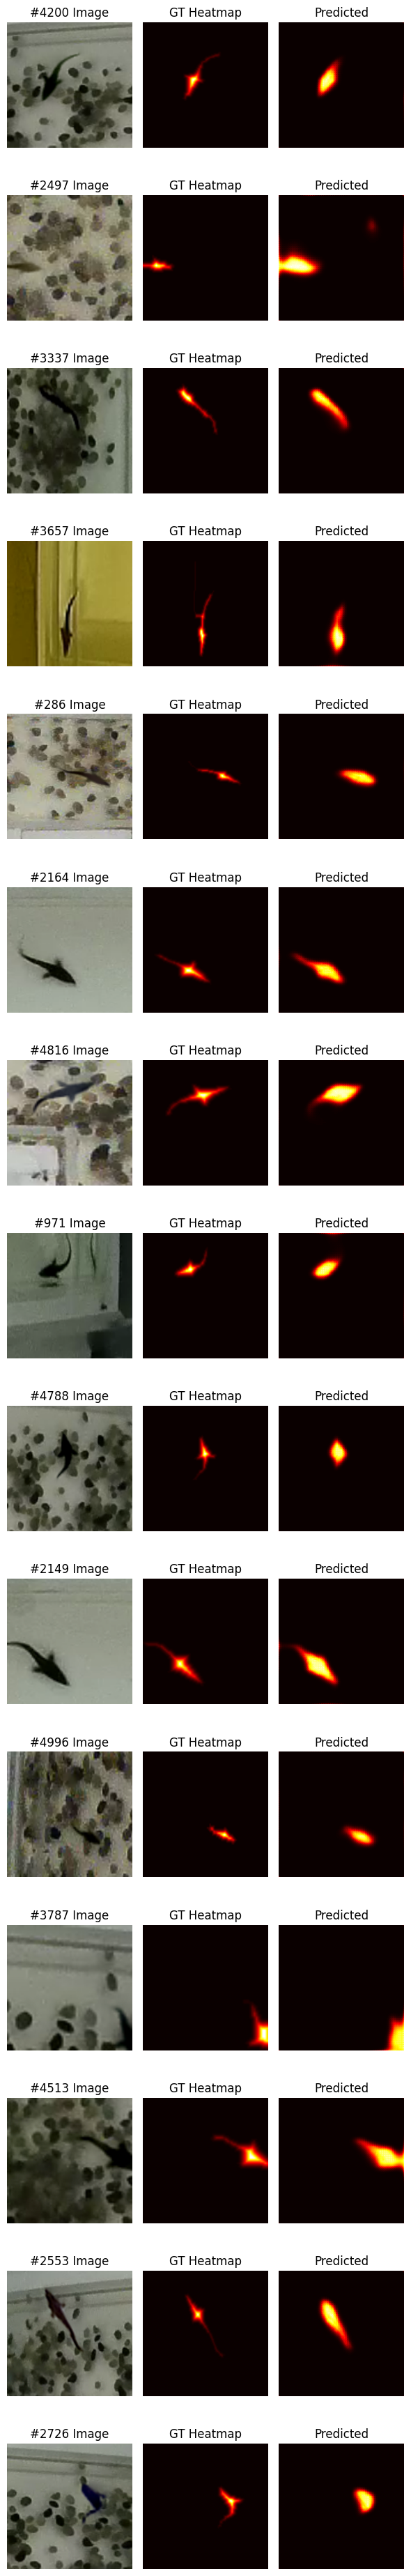

In [20]:
# Load from flagged DataFrame
indices = df.sort_values("distance", ascending=False).head(15)["index"].tolist()

preview_outliers_grid(model, device, train_ds, indices, 15, 1)